# Imports

In [556]:
# ---------------------------------------------- Imports ----------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import time

# INIT

In [557]:
# ---------------------------------------------- Init ----------------------------------------
try:
    client = RemoteAPIClient()
    sim = client.require('sim')
except:
    print('Error connection')

# Constantes

In [558]:
L = 0.230
R = 0.035
ROBOT = "kobuki"
LASER = "fastHokuyo"

robot_path = []
obstacle_points = []

# Tamanho da célula do nosso Grid (em metros)
# CELL_SIZE = 0.01
CELL_SIZE = 0.1
# CELL_SIZE = 0.5

# Dimensão do meu Mapa
MAP_DIMS = np.array([10,10])

#Meu grid
rows, cols = (MAP_DIMS/CELL_SIZE).astype(int)
grid = np.full((rows, cols), 0.5)

#Vetor para realizar a translação!
pBorg = [-5, -5]

#Handles
objectHandle_RP = sim.getObject("/" + ROBOT)
objectHandle_Laser = sim.getObject("/" + LASER)


# Leitura do Sensor

In [559]:
def readSensorData(range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):
    
    signalName = sim.waitForSignal(range_data_signal_id)
    
    string_range_data = sim.getStringSignal(range_data_signal_id)

    string_angle_data = sim.getStringSignal(angle_data_signal_id)

    # verifique se ambos os dados foram obtidos corretamente
    if string_range_data != None and string_angle_data != None:
        # descompacte dados de mensagens de alcance e sensor
        raw_range_data = sim.unpackFloatTable(string_range_data)
        raw_angle_data = sim.unpackFloatTable(string_angle_data)

        return raw_range_data, raw_angle_data

    # retornar nenhum caso nada tenha sido obtido do simulador
    return None

# Transformações

In [560]:
def get_rotation_matrix(thetaZ):
    return np.array([[  np.cos(thetaZ), -np.sin(thetaZ), 0 ],
                      [ np.sin(thetaZ),  np.cos(thetaZ), 0 ],
                      [ 0            ,  0            , 1 ]])

def get_transformation_matrix_laser_world():
    origin_RP = np.array(sim.getObjectPosition(objectHandle_RP, 
                                        sim.handle_world))

    origin_Laser = np.array(sim.getObjectPosition(objectHandle_Laser, 
                                        sim.handle_world))
    p_Laserorg = origin_Laser - origin_RP
    eulerAngles_Laser = sim.getObjectOrientation(objectHandle_Laser, 
                                                objectHandle_RP)

    aux = np.array([0, 0, 0, 1])
    rotationMatrix_Laser = get_rotation_matrix(eulerAngles_Laser[2])
    transformationMatrix_Laser = np.column_stack((rotationMatrix_Laser, p_Laserorg))
    transformationMatrix_Laser = np.row_stack((transformationMatrix_Laser, aux))

    #Matriz de Transformação Robô -> mundo
    origin_World = np.array([0,0,0])
    p_RPorg = origin_RP - origin_World
    eulerAngles_RP = sim.getObjectOrientation(objectHandle_RP, 
                                                sim.handle_world)
    rotationMatrix_RP = get_rotation_matrix(eulerAngles_RP[2])
    transformationMatrix_World = np.column_stack((rotationMatrix_RP, p_RPorg))
    transformationMatrix_World = np.row_stack((transformationMatrix_World, aux))
    
    #Matriz de Transformação Laser -> Mundo
    return transformationMatrix_Laser @ transformationMatrix_World

# Campos Potenciais

In [561]:
#Calcula a força de atração 
def att_force(q, goal, k=5):
    f = k*(goal - q)
    return f

#Calcula a força de repulsão
def rep_force(q, obs, R=1.5, krep=.009):
    Frep_total = np.array([0.0, 0.0])
    for obstacle in obs:
        v = q[0:2] - obstacle
        d = np.linalg.norm(v) # Calcula a distância entre o robô e o obstáculo

        # Calcula a força de repulsão apenas se a distância for menor que R
        if (d < R):  
            rep = (1/d**2)*((1/d)-(1/R))*(v/d) 
            Frep_total += rep

    return krep*Frep_total

# Occupancy Grid

### Log-Odds

In [562]:
def log_odds_by_probability(pA):
    return np.log(pA/(1-pA))

def probability_by_log_odds(lti):
    return 1 - (1/(1 + np.exp(lti)))


### Constantes

In [563]:
l_0 = log_odds_by_probability(0.5)

max_cel = len(grid) - 1

rotation_matrix_neg_pi_half = get_rotation_matrix(-np.pi/2)

max_sensor_range = 5

z_max = max_sensor_range / CELL_SIZE  # Distância máxima do feixe do sensor no grid
alpha = 0.2 / CELL_SIZE

### Inverse Sensor Model

In [564]:
def inverse_sense_model(cell_mi, cell_robot, zkt, l_ant):
    x_i, y_i = cell_mi  # Centro de massa da célula
    x, y = cell_robot  # Posição do robô
    
    # Cálculo explícito da distância r, que representa a distancia entre o robo e o centro da celula mi
    r = np.sqrt((x_i - x)**2 + (y_i - y)**2)
    
    #Se for maior, retorna l_0, indicando que a célula está na área desconhecida.
    if r > min(z_max, zkt + alpha / 2):
        return l_ant
    #Se ambas as condições forem verdadeiras, retorna l_occ, indicando que a célula provavelmente está ocupada.
    if zkt < z_max and abs(r - zkt) < alpha / 2:
        return log_odds_by_probability(0.95)
    #Se for verdadeira, retorna l_free, indicando que a célula está livre.
    if r <= zkt:
        return log_odds_by_probability(0.15)

### Occupancy Grid e Bresenham

In [565]:
def bresenham(x0, y0, x1, y1):
    """Algoritmo de Bresenham para gerar pontos entre (x0, y0) e (x1, y1)."""
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    return points  

# Função principal de mapeamento com navegação
def occupancy_grid_mapping(cell_robot, cell_laser, zkt):
    path = bresenham(cell_robot[0], cell_robot[1], cell_laser[0], cell_laser[1])
    
    for (t, i) in path:
        l_ant = grid[t, i]
        l_cell = l_ant + inverse_sense_model([t, i], cell_robot, zkt, l_ant) - l_0
        grid[t, i] = l_cell

### Conversão Leitura do laser para posição da célula no Grid

In [566]:
def convert_laser_reading_to_cell_values(xo,yo):
    cell =  rotation_matrix_neg_pi_half @ ([xo,yo,0])
    i = (np.floor(cell[0] / CELL_SIZE).astype(int) + pBorg[0]) * (-1) + 45
    j = (np.floor(cell[1] / CELL_SIZE).astype(int) + pBorg[1]) * (-1) + 45
    
    if max_cel < i:
        i = max_cel
    if max_cel < j:
        j = max_cel
    
    return i, j

# Navegação

### Constantes

In [567]:
robotHandle = sim.getObject("/" + ROBOT)  
robotLeftMotorHandle = sim.getObject("/" +'kobuki_leftMotor')
robotRightMotorHandle = sim.getObject("/" +'kobuki_rightMotor')

# maxv = 0.2 #LIMITADORES DA VELOCIDADE LINEAR
maxv = 0.3 #LIMITADORES DA VELOCIDADE LINEAR
maxw = np.deg2rad(45) #LIMITADORES DA VELOCIDADE ANGULAR

random_force = 0.1
kr = 0.05
kt = 0.1

In [568]:
def navigation(qgoal):
    start_time = time.time()
    rho = np.inf

    while rho > .05:
        obstacle = []

        current_time = time.time()
        # elapsed_time = current_time - start_time
        # if elapsed_time >= 60:
        #     break

        #Configuração do robo
        robotPos = sim.getObjectPosition(robotHandle, sim.handle_world)
        robotPos = robotPos[0:2]
        robot_path.append(robotPos)

        rho = np.sqrt((robotPos[0] - qgoal[0])**2 + (robotPos[1] - qgoal[1])**2)

        i_robot, j_robot = convert_laser_reading_to_cell_values(robotPos[0], robotPos[1])
        robotOri = sim.getObjectOrientation(robotHandle, sim.handle_world)        
        robotConfig = np.array([robotPos[0], robotPos[1], robotOri[2]])

        raw_range_data, raw_angle_data = readSensorData()
        laser_data = np.array([raw_angle_data, raw_range_data]).T

        #Transformação dos dados do meu laser para o mundo
        transformationMatrix_LaserWorld = get_transformation_matrix_laser_world()

        for i in range(len(laser_data)):
            ang, dist = laser_data[i] #pega os valores de angulo e distância
            if (max_sensor_range - dist) > 0.1:
                x = dist * np.cos(ang) #meu x
                y = dist * np.sin(ang) #meu y
                point = np.array([x,y,0,1])

                if len(transformationMatrix_LaserWorld) != 0:
                    point = transformationMatrix_LaserWorld @ point
                    obstacle.append(point[0:2])
                    obstacle_points.append(point)
                    i_laser, j_laser = convert_laser_reading_to_cell_values(point[0],point[1])
                    occupancy_grid_mapping(np.array([i_robot, j_robot]), np.array([i_laser, j_laser]), dist/CELL_SIZE)

        
        Fatt = att_force(robotPos, qgoal)
        Frep = rep_force(robotPos, obstacle)

        random_force_vector = random_force * np.random.rand(2)
        Ft = Fatt + Frep + random_force_vector
        Ft_x = Ft[0]
        Ft_y = Ft[1]

        # Apenas para interromper o loop
        # rho = np.sqrt(Ft_x**2 + Ft_y**2)
        
        # Formula De Luca e Oriolo para calcular a velocidade linear e angular.
        v = kr*(Ft_x*np.cos(robotConfig[2]) + Ft_y*np.sin(robotConfig[2]))
        w = kt*(np.arctan2(Ft_y,Ft_x) - robotConfig[2])
                
        # Limit v,w to +/- max
        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)        
        
        vr = ((1.0*v) + (w*L))/(2.0*R)
        vl = ((1.0*v) - (w*L))/(2.0*R)
        sim.setJointTargetVelocity(robotRightMotorHandle, vr)
        sim.setJointTargetVelocity(robotLeftMotorHandle, vl)

    sim.setJointTargetVelocity(robotRightMotorHandle, 0)
    sim.setJointTargetVelocity(robotLeftMotorHandle, 0)



# MAIN CODE

### Testes

In [569]:
# TESTE 1
qgoals = []
qgoals.append([1.5, 3])
# qgoals.append([3.4, 4])
# qgoals.append([0.4, 4])
# qgoals.append([1.0, 0])
# qgoals.append([0.5, -4.5])

### Simulação

In [570]:
sim.startSimulation()

for qgoal in qgoals:
        navigation(np.array(qgoal))

sim.stopSimulation()

### Plot Caminho do robô

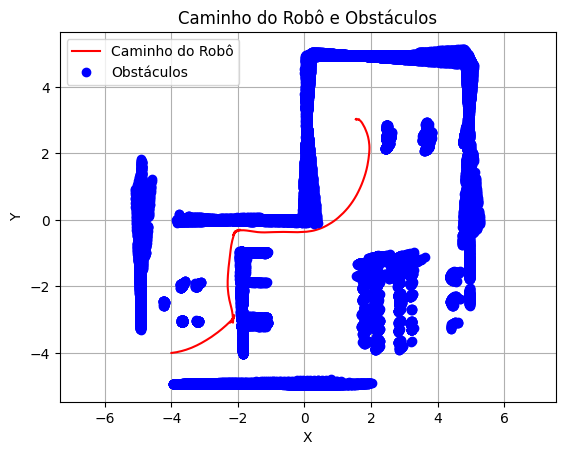

In [571]:
# -------------------------- Plotando o caminho do robô -------------------------
robot_path = np.array(robot_path)
plt.plot(robot_path[:, 0], robot_path[:, 1], '-r', label='Caminho do Robô')
obstacle_points = np.array(obstacle_points)
plt.plot(obstacle_points[:, 0], obstacle_points[:, 1], 'o', color='b', label='Obstáculos')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Caminho do Robô e Obstáculos')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.savefig("robot_path_and_obstacles.png")
plt.show()

### Plot Occupancy Grid

C:\Users\ADM\AppData\Local\Temp\ipykernel_28340\799359859.py:5: RuntimeWarning: overflow encountered in exp
  return 1 - (1/(1 + np.exp(lti)))


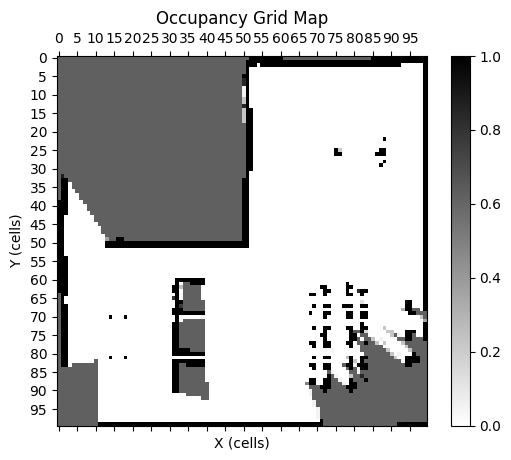

In [572]:
# -------------------------- Normaliza o grid -------------------------
for r in range(rows):
    for c in range(cols):
        probability_grid = grid[r,c]
        grid[r,c] = probability_by_log_odds(probability_grid)

# ------------------ Plotando o occupancy grid -----------------
fig, ax = plt.subplots()

# Exibir a matriz do Occupancy Grid
cax = ax.matshow(grid, cmap='gray_r', vmin=0, vmax=1)

# Adicionar uma barra de cores para referência
fig.colorbar(cax)

# Definir título e rótulos dos eixos
ax.set_title('Occupancy Grid Map')
ax.set_xlabel('X (cells)')
ax.set_ylabel('Y (cells)')

# ax.set_xticks(np.arange(0, MAP_DIMS[1]+1, CELL_SIZE))
# ax.set_yticks(np.arange(0, MAP_DIMS[0]+1, CELL_SIZE))
ticks = np.arange(0, grid.shape[0], step=5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
# ax.set_xticklabels(ticks)
# ax.set_yticklabels(ticks)

# Salvar a figura como uma imagem
plt.savefig("occupancy_grid_map.png")
plt.show()